<a href="https://colab.research.google.com/github/Aaricis/Hung-yi-Lee-ML2021/blob/main/ML2021_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

# **Result**

scores (pass strong baseline):
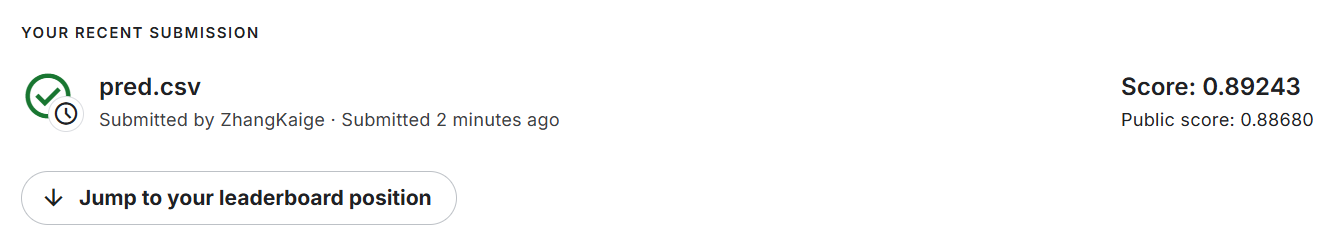

strong baseline:
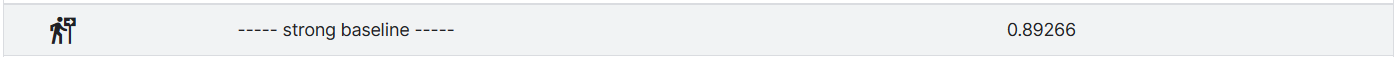


# **基于medium baseline的分析与改善**

**1.修改助教Sample Code中的两个错误**
- hw1 ppt介绍的损失函数是RMSE，代码实际使用MSE（但是改成RMSE其实没什么用）。
- 数据归一化方式有误。对于不同的dataset，原Code使用各自的mean和std作归一。正确的做法是**使用相同的归一化参数**：
  - 在对训练集进行归一化时，通常会计算一些参数（如均值、标准差或最大值/最小值）。在对测试集进行归一化时，必须使用这些相同的参数，而不是重新计算测试集的参数。

**2.Feature Selection**
- hw1跟平常见到的深度学习任务不太一样，有点像传统的机器学习任务，特征选择对结果影响很大。
- 选择相关性较大的15个feature作为输入数据。

**3.损失函数**
- 增加L2正则项

**4.网络结构**
- 这个任务较简单，增加网络的复杂度会造成overfitting。

**总结：**

hw1与通常意义上的深度学习任务不同，Feature Selection起到很大作用，而不是调整网络结构。hw1更像是传统机器学习向深度学习的一个过渡。


# **Download Data**

In [ ]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 90.1MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 105MB/s]


# **Import Some Packages**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import csv
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


myseed = 42069
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Data Analysis and Some Utilities**

In [ ]:
train_data = pd.read_csv(tr_path)
train_data = train_data.drop(["id"], axis=1)
train_data.corr()

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
AL,1.000000,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,...,0.210928,0.202805,0.279239,-0.073966,-0.153556,-0.035570,-0.170177,-0.273551,-0.047698,0.063479
AK,-0.025446,1.000000,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,...,-0.013452,0.051009,0.029212,0.194813,0.017483,0.059403,0.153638,-0.179413,-0.098627,-0.152682
AZ,-0.025446,-0.025446,1.000000,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,...,0.177914,0.108104,0.098514,0.087006,-0.136689,-0.052381,-0.059705,-0.206808,-0.157999,-0.162097
AR,-0.025446,-0.025446,-0.025446,1.000000,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,...,0.112250,0.146078,0.187179,-0.117037,0.077963,0.218993,-0.021997,-0.127898,0.035605,0.030706
CA,-0.025446,-0.025446,-0.025446,-0.025446,1.000000,-0.025446,-0.025446,-0.025446,-0.025446,-0.025446,...,0.027648,0.016425,-0.046107,0.104119,-0.018843,-0.007374,0.058020,-0.093832,-0.079045,-0.208291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
depressed.2,-0.035570,0.059403,-0.052381,0.218993,-0.007374,0.071091,-0.159754,-0.201005,-0.129952,0.037010,...,-0.067040,0.118125,0.066021,-0.164079,0.594797,1.000000,0.610310,-0.051246,0.026621,0.029578
felt_isolated.2,-0.170177,0.153638,-0.059705,-0.021997,0.058020,0.020721,-0.172719,-0.195154,-0.179562,-0.032974,...,-0.641984,-0.507902,-0.554675,0.009571,0.525171,0.610310,1.000000,0.407931,0.132465,0.081174
worried_become_ill.2,-0.273551,-0.179413,-0.206808,-0.127898,-0.093832,-0.120136,0.038770,-0.168653,-0.203301,-0.276828,...,-0.831868,-0.870630,-0.875487,-0.047068,0.251509,-0.051246,0.407931,1.000000,0.495890,0.267610
worried_finances.2,-0.047698,-0.098627,-0.157999,0.035605,-0.079045,-0.123659,-0.092067,-0.065390,-0.077847,-0.188089,...,-0.435929,-0.524228,-0.380926,-0.142098,0.184126,0.026621,0.132465,0.495890,1.000000,0.485843


In [ ]:
feats = []
for idx, data in enumerate(train_data.corr()["tested_positive.2"].abs()):
  if data > 0.48 and idx != 93:
    feats.append(idx)

print(feats)

[40, 41, 42, 43, 57, 58, 59, 60, 61, 74, 75, 76, 77, 78, 79, 92]


In [ ]:
with open("covid.train.csv", "r") as fp:
    train_data = list(csv.reader(fp))
    train_data = np.array(train_data[1:])[:, 1:-1].astype(float)

mean = torch.FloatTensor(train_data[:, feats]).mean(dim=0, keepdim=True)
std = torch.FloatTensor(train_data[:, feats]).std(dim=0, keepdim=True)

In [ ]:
mean, std

(tensor([[ 0.9916,  1.0161, 29.4425, 24.3231, 16.3009,  0.9946,  1.0191, 29.5293,
          24.4029, 44.5441, 16.3667,  0.9980,  1.0225, 29.6108, 24.4779, 44.5684]]),
 tensor([[0.4203, 0.4236, 9.0937, 8.4468, 7.6378, 0.4201, 0.4235, 9.0829, 8.4431,
          5.2488, 7.6275, 0.4202, 0.4237, 9.0705, 8.4370, 5.2320]]))

In [ ]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Dataset and DataLoader**

In [ ]:
class COVID19Dataset(Dataset):
    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode

        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if mode == 'test':
          data = data[:, feats]
          self.data = torch.FloatTensor(data)

        else:
          target = data[:, -1]
          data = data[:, feats]

          if mode == 'train':
            indices = [i for i in range(len(data)) if i % 10 != 0]
          elif mode == 'dev':
            indices = [i for i in range(len(data)) if i % 10 == 0]

          self.data = torch.FloatTensor(data[indices])
          self.target = torch.FloatTensor(target[indices])


        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

        self.data = (self.data - mean) / std

    def __getitem__(self, index):

        if self.mode in ['train', 'dev']:

            return self.data[index], self.target[index]
        else:

            return self.data[index]

    def __len__(self):

        return len(self.data)

In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    return dataloader

# **Deep Neural Network**

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
      loss = self.criterion(pred, target)
      l2 = 0
      for i in self.parameters():
        l2 += torch.sum(pow(i, 2))

      return loss + 0.002 * l2, loss

# **Train/Dev/Test**

In [ ]:
def train(tr_set, dv_set, model, config, device):

    n_epochs = config['n_epochs']

    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in tr_set:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            l2_loss, mse_loss = model.cal_loss(pred, y)
            l2_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [ ]:
def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            _, mse_loss = model.cal_loss(pred, y)
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
    return total_loss

In [ ]:
def test(tt_set, model, device):
    model.eval()
    preds = []
    for x in tt_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# **Setup Hyper-parameters**

In [ ]:
device = get_device()
os.makedirs('models', exist_ok=True)
target_only = False

config = {
    'n_epochs': 3000,
    'batch_size': 128,
    'optimizer': 'SGD',
    'optim_hparas': {
        'lr': 0.0001,
        'momentum': 0.9
    },
    'early_stop': 200,
    'save_path': 'models/model.pth'
}

# **Load data and model**

In [ ]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 16)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 16)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 16)


In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)

# **Start Training**

In [ ]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 279.0623)
Saving model (epoch =    2, loss = 154.1063)
Saving model (epoch =    3, loss = 81.4683)
Saving model (epoch =    4, loss = 66.0441)
Saving model (epoch =    5, loss = 55.0105)
Saving model (epoch =    6, loss = 45.6889)
Saving model (epoch =    7, loss = 37.6201)
Saving model (epoch =    8, loss = 29.5949)
Saving model (epoch =    9, loss = 21.9064)
Saving model (epoch =   10, loss = 14.5768)
Saving model (epoch =   11, loss = 9.2944)
Saving model (epoch =   12, loss = 6.3040)
Saving model (epoch =   13, loss = 4.6133)
Saving model (epoch =   14, loss = 3.7288)
Saving model (epoch =   15, loss = 3.1454)
Saving model (epoch =   16, loss = 2.6874)
Saving model (epoch =   17, loss = 2.3318)
Saving model (epoch =   18, loss = 2.0698)
Saving model (epoch =   19, loss = 1.8800)
Saving model (epoch =   20, loss = 1.7483)
Saving model (epoch =   21, loss = 1.6439)
Saving model (epoch =   22, loss = 1.5698)
Saving model (epoch =   23, loss = 1.4976)

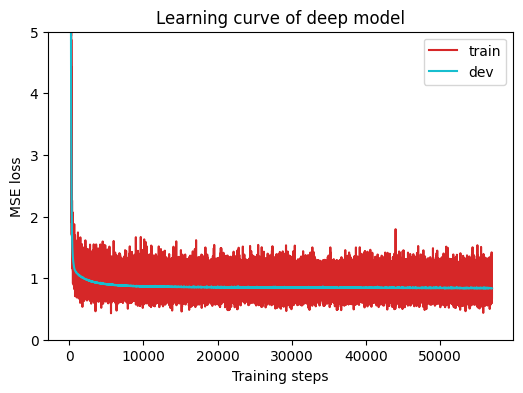

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

<ipython-input-19-ff750adea3b1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(config['save_path'], map_location='cpu')


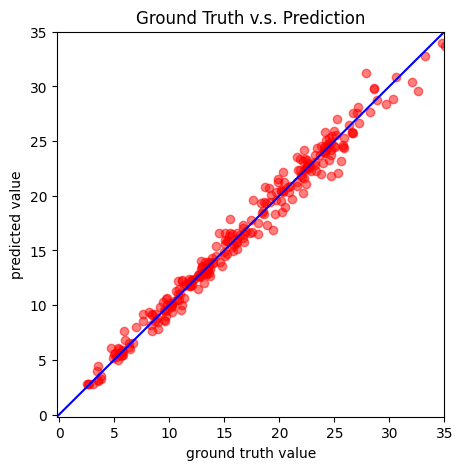

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)

# **Testing**

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')

Saving results to pred_shuffle.csv
